In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re

import string
#from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [2]:
df=pd.read_csv('../csv/product_product.csv')

In [3]:
df.describe()

,overall,count
count,346355.000000,346355.000000
mean,4.274958,19.536493
std,1.120213,28.546791
min,1.000000,5.000000
25%,4.000000,6.000000
50%,5.000000,10.000000
75%,5.000000,20.000000
max,5.000000,1089.000000


In [4]:
def min_reviews_req(df):
    x=df.describe()
    min_count=x.loc['50%','count']
    #considering top 50% products by reviews count......
    new_df=df[df['count']>=min_count]
    return new_df
    
    

In [6]:
new_df=min_reviews_req(df)

In [7]:
new_df.index.size

181489

In [8]:
new_df.head()

,asin,summary,overall,count
164866,B002DWA2H4,med cabinet standard,5,10
164867,B002DWA2H4,So glad the ban on Excedrin was lifted,4,10
164868,B002DWA2H4,my go to,5,10
164869,B002DWA2H4,My old stand-by,5,10
164870,B002DWA2H4,Nothing better for my headaches,5,10


In [8]:
new_df.describe()

,overall,count
count,181489.000000,181489.000000
mean,4.273548,31.369185
std,1.103638,35.486832
min,1.000000,10.000000
25%,4.000000,13.000000
50%,5.000000,19.000000
75%,5.000000,37.000000
max,5.000000,1089.000000


In [9]:
dfProductReview=new_df.groupby("asin", as_index=False).mean()

In [10]:
dfProductReview.asin.unique().size

9234

In [13]:
dfProductReview.head()

,asin,overall,count
0,B002DWA2H4,4.888889,10.0
1,B002DWA3AA,4.437500,10.0
2,B002DXZIOU,4.214286,10.0
3,B002DYIZIU,4.022727,10.0
4,B002DYIZO4,5.000000,10.0


In [19]:
ProductReviewSummary = new_df.groupby("asin")["summary"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.reset_index(inplace=True)

In [20]:
ProductReviewSummary.head()

,asin,summary
0,B002DWA2H4,"[med cabinet standard, So glad the ban on Exce..."
1,B002DWA3AA,"[Palatable, Tasty and helpful, Not perfect but..."
2,B002DXZIOU,"[Nice, Great, Good product, bad packaging, I d..."
3,B002DYIZIU,"[No Rush But Certainly Helpful, Need Your BCAA..."
4,B002DYIZO4,"[Flavored Beta-Alanine, WHAT?!, Beta Alanine (..."


In [13]:
ProductReviewSummary.to_csv("../csv/ProductReviewSummary.csv",index=False)

In [24]:
ProductReviewSummary=pd.read_csv("../csv/ProductReviewSummary.csv")

In [25]:
ProductReviewSummary.head()

,asin,summary
0,B002DWA2H4,"['med cabinet standard', 'So glad the ban on E..."
1,B002DWA3AA,"['Palatable', 'Tasty and helpful', 'Not perfec..."
2,B002DXZIOU,"['Nice', 'Great', 'Good product, bad packaging..."
3,B002DYIZIU,"['No Rush But Certainly Helpful', 'Need Your B..."
4,B002DYIZO4,"['Flavored Beta-Alanine, WHAT?!', 'Beta Alanin..."


In [26]:
dfMerged=pd.merge(ProductReviewSummary,dfProductReview,on='asin')

In [27]:
dfMerged.drop('count',inplace=True,axis=1)

In [28]:
dfMerged.head()

,asin,summary,overall
0,B002DWA2H4,"['med cabinet standard', 'So glad the ban on E...",4.888889
1,B002DWA3AA,"['Palatable', 'Tasty and helpful', 'Not perfec...",4.437500
2,B002DXZIOU,"['Nice', 'Great', 'Good product, bad packaging...",4.214286
3,B002DYIZIU,"['No Rush But Certainly Helpful', 'Need Your B...",4.022727
4,B002DYIZO4,"['Flavored Beta-Alanine, WHAT?!', 'Beta Alanin...",5.000000


# Text Cleaning - Summary column

In [29]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = str.lower(reviewText)
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [30]:
dfMerged.head()

,asin,summary,overall
0,B002DWA2H4,"['med cabinet standard', 'So glad the ban on E...",4.888889
1,B002DWA3AA,"['Palatable', 'Tasty and helpful', 'Not perfec...",4.437500
2,B002DXZIOU,"['Nice', 'Great', 'Good product, bad packaging...",4.214286
3,B002DYIZIU,"['No Rush But Certainly Helpful', 'Need Your B...",4.022727
4,B002DYIZO4,"['Flavored Beta-Alanine, WHAT?!', 'Beta Alanin...",5.000000


In [31]:
#reset index and drop duplicate rows
dfMerged['clean_summary'] = dfMerged['summary'].apply(lambda x:cleanReviews(x))
#dfMerged = dfMerged.drop_duplicates(['overall'], keep='last')
#dfMerged = dfMerged.reset_index()

In [32]:
dfMerged.index.size

9234

In [33]:
dfMerged.head()

,asin,summary,overall,clean_summary
0,B002DWA2H4,"['med cabinet standard', 'So glad the ban on E...",4.888889,med cabinet standard so glad the ban on excedr...
1,B002DWA3AA,"['Palatable', 'Tasty and helpful', 'Not perfec...",4.437500,palatable tasty and helpful not perfect but cl...
2,B002DXZIOU,"['Nice', 'Great', 'Good product, bad packaging...",4.214286,nice great good product bad packaging i don t ...
3,B002DYIZIU,"['No Rush But Certainly Helpful', 'Need Your B...",4.022727,no rush but certainly helpful need your bcaas ...
4,B002DYIZO4,"['Flavored Beta-Alanine, WHAT?!', 'Beta Alanin...",5.000000,flavored beta alanine what beta alanine bka th...


In [34]:
reviews = dfMerged["clean_summary"] 
countVector = CountVectorizer(max_features = 400, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

In [37]:
transformedReviews.A
#print(transformedReviews)
dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
#dfReviews = dfReviews.astype(int)

In [40]:
product_id=pd.DataFrame()
product_id[['asin','overall']]=dfMerged[['asin','overall']]

In [41]:
product_id.to_csv("../csv/product_id.csv",index=False,sep=',')

In [42]:
product_id=pd.read_csv("../csv/product_id.csv")

In [47]:
product_id.head()

,asin,overall
0,B002DWA2H4,4.888889
1,B002DWA3AA,4.437500
2,B002DXZIOU,4.214286
3,B002DYIZIU,4.022727
4,B002DYIZO4,5.000000


In [44]:
dfReviews=product_id.join(dfReviews)

In [45]:
#save 
dfReviews.to_csv("../csv/Summary_Feature.csv",index=False)

In [48]:
dfReviews=pd.read_csv("../csv/Summary_Feature.csv")

In [21]:
from sklearn.cross_validation import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [50]:
#test train spilt.....
train,test=train_test_split(dfReviews,test_size=0.3)
print("Train sample size ",train.index.size)
print("Test sample size ",test.index.size)

train_features=train.drop(['asin','overall'],axis=1)
test_features=test.drop(['asin','overall'],axis=1)
           
train_array=np.array(train_features)
test_array=np.array(test_features)

Train sample size  6463
Test sample size  2771


In [51]:
train.to_csv('../csv/train.csv',index=False)
test.to_csv('../csv/test.csv',index=False)

In [52]:
train=pd.read_csv('../csv/train.csv')
test=pd.read_csv('../csv/test.csv')

In [54]:
neighbor = NearestNeighbors(n_neighbors=22)
neighbor.fit(train.drop(['asin','overall'],axis=1))
#using knn algo for predictions..
distances, indices = neighbor.kneighbors(train_array)

In [57]:
#distances of neighbor from given product(point)
distances

array([[  0.        ,   7.54983444,   7.93725393, ...,  10.        ,
         10.04987562,  10.14889157],
       [  0.        ,   2.82842712,   2.82842712, ...,   3.16227766,
          3.16227766,   3.16227766],
       [  0.        ,   9.59166305,  10.24695077, ...,  10.81665383,
         10.86278049,  10.86278049],
       ..., 
       [  0.        ,   2.82842712,   3.        , ...,   3.16227766,
          3.31662479,   3.31662479],
       [  0.        ,   9.43398113,   9.53939201, ...,  10.29563014,
         10.34408043,  10.34408043],
       [  0.        ,   2.82842712,   3.        , ...,   3.46410162,
          3.46410162,   3.46410162]])

In [58]:
# ids of the neighbor from given porduct
indices

array([[   0, 4654, 2290, ..., 2585, 5232, 3667],
       [   1, 4728, 1971, ..., 6209, 3663, 6285],
       [   2, 4225,  972, ...,  105,  614, 2986],
       ..., 
       [6460, 1299, 6002, ...,  768, 2148, 2431],
       [6461, 2932, 1778, ..., 6186, 4856,  627],
       [6462, 4595, 3544, ..., 3232,  875, 6209]], dtype=int64)

In [61]:
indices.shape

(6463, 22)

In [55]:
test.head()

,asin,overall,absolutely,accurate,actually,advertised,aid,allergy,alternative,amazing,...,worked,working,workout,works,worth,wow,year,years,yes,yummy
0,B00J7WIQNU,5.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B004NEHR28,4.671429,0,0,0,0,0,0,0,1,...,0,0,0,10,0,0,0,0,0,0
2,B00B15E7P2,4.448718,0,0,0,0,0,0,2,0,...,0,0,0,16,0,0,0,0,0,0
3,B007ADLJ0A,4.636364,1,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
4,B007JCAKCU,4.833333,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [44]:
product_id.iloc[0]['asin']

'B002DWA2H4'

In [45]:
test.asin.iloc[1]

'B004NCJXIG'

In [59]:
#find most related products
for i in range(test.index.size):
    a = neighbor.kneighbors([test_array[i]])
    #print(a)
    #print(a[0])               # a[0] is the distance
    #print(a[1])                # a[1] is the indices 
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
                             
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    third_related_product = [item[2] for item in related_product_list]
    third_related_product = str(third_related_product).strip('[]')
    third_related_product = int(third_related_product)
    
    test_product=test.asin.iloc[i]
    s1=product_id['asin'][first_related_product]
    s2=product_id['asin'][second_related_product]
    s3=product_id['asin'][third_related_product]
    

    print ("Based on product reviews, for ",test_product," average rating is ",test.overall.iloc[i])
    print ("The first similar product is ", s1 ," average rating is ",product_id["overall"][first_related_product])
    print ("The second similar product is ",s2 ," average rating is ",product_id["overall"][second_related_product])
    print ("The third similar product is ",s3 ," average rating is ",product_id["overall"][third_related_product])
    print ("\n")
    

Based on product reviews, for  B00J7WIQNU  average rating is  5.0
The first similar product is  B005WPFX8W  average rating is  4.16666666667
The second similar product is  B004L4ANAS  average rating is  4.18181818182
The third similar product is  B008B0MTUU  average rating is  4.6


Based on product reviews, for  B004NEHR28  average rating is  4.67142857143
The first similar product is  B0087S7WXU  average rating is  3.14285714286
The second similar product is  B007Z6D5SQ  average rating is  4.36363636364
The third similar product is  B003TVTXNM  average rating is  4.66666666667


Based on product reviews, for  B00B15E7P2  average rating is  4.44871794872
The first similar product is  B005ED3S7U  average rating is  4.33333333333
The second similar product is  B0069SQW5O  average rating is  4.77272727273
The third similar product is  B0046W2IK8  average rating is  4.77777777778


Based on product reviews, for  B007ADLJ0A  average rating is  4.63636363636
The first similar product is  B0

Based on product reviews, for  B002G2VENC  average rating is  4.66666666667
The first similar product is  B007RA6A3M  average rating is  3.66666666667
The second similar product is  B005P0I6II  average rating is  4.8
The third similar product is  B005GNL5G4  average rating is  4.51063829787


Based on product reviews, for  B002KHNL3E  average rating is  4.09090909091
The first similar product is  B004XKUD78  average rating is  4.8125
The second similar product is  B007IE5MPE  average rating is  4.10526315789
The third similar product is  B003EMPN7G  average rating is  4.25


Based on product reviews, for  B003XU8ABA  average rating is  4.5
The first similar product is  B002LMD796  average rating is  4.22222222222
The second similar product is  B007A1XBUS  average rating is  4.28571428571
The third similar product is  B0044Q8VG6  average rating is  4.4


Based on product reviews, for  B0052KONSI  average rating is  3.38709677419
The first similar product is  B003FBOJDK  average rating i

Based on product reviews, for  B006F8YJGM  average rating is  4.46153846154
The first similar product is  B0039ORBMY  average rating is  3.6
The second similar product is  B004AKRUOU  average rating is  4.0
The third similar product is  B004N1P3GI  average rating is  4.6


Based on product reviews, for  B00BJUFGB8  average rating is  4.6
The first similar product is  B003H5SXDQ  average rating is  4.42857142857
The second similar product is  B002MXYLIK  average rating is  4.875
The third similar product is  B003T5TKEA  average rating is  4.86666666667


Based on product reviews, for  B0097ACVP6  average rating is  4.11764705882
The first similar product is  B005GP93TS  average rating is  3.5
The second similar product is  B007WFXQ8Y  average rating is  3.4
The third similar product is  B005JRZJBO  average rating is  4.73684210526


Based on product reviews, for  B003XMTZWQ  average rating is  4.33333333333
The first similar product is  B0062A6YW0  average rating is  3.33333333333
The s

Based on product reviews, for  B004L4EING  average rating is  4.06611570248
The first similar product is  B0041HZUK8  average rating is  4.45454545455
The second similar product is  B0086VIA20  average rating is  4.35714285714
The third similar product is  B004UDWU6K  average rating is  4.57142857143


Based on product reviews, for  B003FBOJB2  average rating is  4.5
The first similar product is  B002PIXZB6  average rating is  3.85714285714
The second similar product is  B003DLZ0OE  average rating is  4.38888888889
The third similar product is  B004LT0P56  average rating is  5.0


Based on product reviews, for  B00AU1IBLY  average rating is  4.11320754717
The first similar product is  B004UOTUXK  average rating is  3.6
The second similar product is  B002PIXZB6  average rating is  3.85714285714
The third similar product is  B003ULEK98  average rating is  5.0


Based on product reviews, for  B004ODQJX6  average rating is  3.92857142857
The first similar product is  B003SP4QAE  average ra

Based on product reviews, for  B004A3R8D0  average rating is  4.66666666667
The first similar product is  B0086VI9SU  average rating is  4.71428571429
The second similar product is  B002W6Z0YG  average rating is  3.88888888889
The third similar product is  B003DW9XWI  average rating is  4.4


Based on product reviews, for  B008IC0Y80  average rating is  4.63636363636
The first similar product is  B002ET7AZ8  average rating is  4.30769230769
The second similar product is  B002QW3EA8  average rating is  4.72727272727
The third similar product is  B007SY2E46  average rating is  4.0


Based on product reviews, for  B0038M6CTK  average rating is  3.375
The first similar product is  B002PYLOX6  average rating is  4.69230769231
The second similar product is  B003KR60MW  average rating is  4.11111111111
The third similar product is  B005FO2Y5A  average rating is  4.58333333333


Based on product reviews, for  B0034L4YGI  average rating is  4.375
The first similar product is  B004PTEVUC  averag

Based on product reviews, for  B00C8BERCQ  average rating is  4.33333333333
The first similar product is  B005MKY9LO  average rating is  4.8
The second similar product is  B004L4ANAS  average rating is  4.18181818182
The third similar product is  B0061ITIRG  average rating is  4.9


Based on product reviews, for  B002FU63KO  average rating is  3.92063492063
The first similar product is  B007ZUTUI6  average rating is  4.84615384615
The second similar product is  B007WB1CJI  average rating is  4.5
The third similar product is  B004R8S7VK  average rating is  3.95454545455


Based on product reviews, for  B00CMGS3OA  average rating is  3.30769230769
The first similar product is  B007H3ACY2  average rating is  4.66666666667
The second similar product is  B004F8AIRI  average rating is  3.8
The third similar product is  B004AJ7P4G  average rating is  4.6


Based on product reviews, for  B007YUWNAE  average rating is  4.0
The first similar product is  B005YU8SGY  average rating is  4.285714285

Based on product reviews, for  B003XZ0S2E  average rating is  3.11111111111
The first similar product is  B008B0T5KW  average rating is  4.55555555556
The second similar product is  B004L4ANAS  average rating is  4.18181818182
The third similar product is  B003ZW9LOQ  average rating is  3.29032258065


Based on product reviews, for  B008COSNMS  average rating is  3.57142857143
The first similar product is  B002QP9FAS  average rating is  4.28571428571
The second similar product is  B003RLOBOK  average rating is  3.5
The third similar product is  B002YC7HSU  average rating is  4.0


Based on product reviews, for  B002TS795K  average rating is  3.8
The first similar product is  B003ONZF1O  average rating is  4.73333333333
The second similar product is  B00651OP90  average rating is  4.71428571429
The third similar product is  B002GHD0AW  average rating is  3.3


Based on product reviews, for  B006R3FOKK  average rating is  4.05555555556
The first similar product is  B004C3OWUU  average ra

Based on product reviews, for  B00DJL6UJW  average rating is  4.5
The first similar product is  B002YLYEPU  average rating is  5.0
The second similar product is  B003TS12WK  average rating is  4.09090909091
The third similar product is  B0052WV9L0  average rating is  4.25


Based on product reviews, for  B0035LBN3O  average rating is  4.05555555556
The first similar product is  B002VLZ8BC  average rating is  4.1
The second similar product is  B004IXZJ4W  average rating is  4.2962962963
The third similar product is  B0050OZZ24  average rating is  4.4


Based on product reviews, for  B00BY6YQZY  average rating is  3.16666666667
The first similar product is  B002GHD0AW  average rating is  3.3
The second similar product is  B002XULC5C  average rating is  3.4
The third similar product is  B002IX1966  average rating is  4.81818181818


Based on product reviews, for  B002G4FUNU  average rating is  4.57142857143
The first similar product is  B007WFXQ8Y  average rating is  3.4
The second simila

The second similar product is  B004AI34FG  average rating is  5.0
The third similar product is  B003E62H26  average rating is  4.2


Based on product reviews, for  B00FA53Q8S  average rating is  4.5
The first similar product is  B0044QZCOU  average rating is  4.0
The second similar product is  B003FBOMPK  average rating is  3.875
The third similar product is  B004PTEVUC  average rating is  3.14285714286


Based on product reviews, for  B002FJW3ZY  average rating is  4.20289855072
The first similar product is  B007MTAOQ2  average rating is  4.33333333333
The second similar product is  B0079BZCVU  average rating is  3.69230769231
The third similar product is  B0035MOOPC  average rating is  4.85714285714


Based on product reviews, for  B0044B5Z2O  average rating is  4.4
The first similar product is  B008A6N49U  average rating is  4.13333333333
The second similar product is  B004CQ5N00  average rating is  4.68
The third similar product is  B002IX1966  average rating is  4.81818181818


Ba

Based on product reviews, for  B0043P0GRA  average rating is  4.65289256198
The first similar product is  B003BRETQU  average rating is  4.0
The second similar product is  B003YZF6PM  average rating is  3.5
The third similar product is  B004IJYG72  average rating is  3.9375


Based on product reviews, for  B00BEDVL9Q  average rating is  4.4
The first similar product is  B004L4ANAS  average rating is  4.18181818182
The second similar product is  B008B0T5KW  average rating is  4.55555555556
The third similar product is  B004GDW63G  average rating is  4.8


Based on product reviews, for  B002YB0AHQ  average rating is  4.57894736842
The first similar product is  B0047E3LHE  average rating is  4.30769230769
The second similar product is  B0045SRGZA  average rating is  3.44444444444
The third similar product is  B007ZHX0OY  average rating is  4.16666666667


Based on product reviews, for  B004YIX23Q  average rating is  4.33333333333
The first similar product is  B003156NJI  average rating is

Based on product reviews, for  B002ZG8HAM  average rating is  4.16666666667
The first similar product is  B00860XL5M  average rating is  3.71428571429
The second similar product is  B003USB93G  average rating is  4.5
The third similar product is  B0050D26TU  average rating is  5.0


Based on product reviews, for  B007A40S42  average rating is  4.4
The first similar product is  B00832SYOG  average rating is  4.1
The second similar product is  B005GNL5G4  average rating is  4.51063829787
The third similar product is  B004XDKRXK  average rating is  3.83333333333


Based on product reviews, for  B0066QZCMI  average rating is  4.71428571429
The first similar product is  B004PTEVUC  average rating is  3.14285714286
The second similar product is  B007SY2E46  average rating is  4.0
The third similar product is  B003VS5O3Q  average rating is  4.34928229665


Based on product reviews, for  B00BB5YFEU  average rating is  3.87804878049
The first similar product is  B004HGJ9EG  average rating is  3

Based on product reviews, for  B007CNKM42  average rating is  4.0
The first similar product is  B007UOG3OG  average rating is  4.71428571429
The second similar product is  B004U71ASK  average rating is  4.55555555556
The third similar product is  B005NZ4IBY  average rating is  5.0


Based on product reviews, for  B004ASER98  average rating is  4.62790697674
The first similar product is  B004A9TK0S  average rating is  4.33333333333
The second similar product is  B005BOQHB6  average rating is  4.38888888889
The third similar product is  B002EVPWXI  average rating is  4.22857142857


Based on product reviews, for  B00CYLJZ7W  average rating is  4.8
The first similar product is  B00763M03O  average rating is  4.6
The second similar product is  B003HFGIBU  average rating is  4.25
The third similar product is  B00893XJMQ  average rating is  4.66666666667


Based on product reviews, for  B003KVO05M  average rating is  2.94736842105
The first similar product is  B003GDKH9C  average rating is  

Based on product reviews, for  B003IUGHSI  average rating is  4.15789473684
The first similar product is  B006FG67KK  average rating is  2.6
The second similar product is  B002JVWZSI  average rating is  3.0
The third similar product is  B004B88BQW  average rating is  4.04347826087


Based on product reviews, for  B00L5L7ZPQ  average rating is  5.0
The first similar product is  B0037ACVW0  average rating is  3.83333333333
The second similar product is  B005YETQMA  average rating is  4.75
The third similar product is  B00598SS70  average rating is  4.2


Based on product reviews, for  B0085WEKRE  average rating is  4.6
The first similar product is  B003CP153G  average rating is  4.42857142857
The second similar product is  B007UZNR08  average rating is  3.74193548387
The third similar product is  B004YIFA0Y  average rating is  5.0


Based on product reviews, for  B004HR208M  average rating is  3.38888888889
The first similar product is  B002RTNUEA  average rating is  4.65625
The second s

Based on product reviews, for  B003V01050  average rating is  3.4
The first similar product is  B007SORR3E  average rating is  4.31818181818
The second similar product is  B0042R86XK  average rating is  2.375
The third similar product is  B004TG73QA  average rating is  4.0


Based on product reviews, for  B003CFB2A2  average rating is  3.85714285714
The first similar product is  B002YC7HSU  average rating is  4.0
The second similar product is  B0037ZUTK6  average rating is  3.90909090909
The third similar product is  B007A1XBUS  average rating is  4.28571428571


Based on product reviews, for  B005YU8UXA  average rating is  4.0
The first similar product is  B00498MSJ0  average rating is  4.31818181818
The second similar product is  B002FJW16U  average rating is  4.0
The third similar product is  B0071N01PI  average rating is  4.92307692308


Based on product reviews, for  B005N0RGQI  average rating is  4.4
The first similar product is  B002GHD0AW  average rating is  3.3
The second simi

The third similar product is  B002VLZ89Y  average rating is  4.22222222222


Based on product reviews, for  B003ZCWZSK  average rating is  3.42857142857
The first similar product is  B004VCMDRG  average rating is  4.66666666667
The second similar product is  B0062QLGIQ  average rating is  4.33333333333
The third similar product is  B0085YJ41O  average rating is  3.7


Based on product reviews, for  B002QW3EA8  average rating is  4.72727272727
The first similar product is  B005JIJRZ2  average rating is  4.42105263158
The second similar product is  B0040HE97Y  average rating is  5.0
The third similar product is  B007SY2E46  average rating is  4.0


Based on product reviews, for  B00BJV0CHU  average rating is  4.27272727273
The first similar product is  B0042A9UXC  average rating is  4.62711864407
The second similar product is  B004HCUMAA  average rating is  4.61538461538
The third similar product is  B003AYEHGQ  average rating is  4.46153846154


Based on product reviews, for  B004OVH8H4

Based on product reviews, for  B003CYKZSS  average rating is  3.0
The first similar product is  B0048IHB3Y  average rating is  4.5
The second similar product is  B004L4ANAS  average rating is  4.18181818182
The third similar product is  B00331RPJW  average rating is  3.83333333333


Based on product reviews, for  B00GXG96TQ  average rating is  5.0
The first similar product is  B006RFI1M6  average rating is  2.75
The second similar product is  B005N7EUSS  average rating is  3.96153846154
The third similar product is  B005DCCU6C  average rating is  4.42307692308


Based on product reviews, for  B00424KI9I  average rating is  4.75
The first similar product is  B002WD1RLE  average rating is  3.73333333333
The second similar product is  B006KXSOA4  average rating is  4.63636363636
The third similar product is  B005Y01BGS  average rating is  4.5


Based on product reviews, for  B007EV88DO  average rating is  4.16666666667
The first similar product is  B002SFXTV2  average rating is  5.0
The s

Based on product reviews, for  B003QYFVDI  average rating is  4.08
The first similar product is  B003N3IRKG  average rating is  4.375
The second similar product is  B006RI49KQ  average rating is  4.8
The third similar product is  B003F13FMQ  average rating is  4.83333333333


Based on product reviews, for  B00FA82IFW  average rating is  5.0
The first similar product is  B0054L61N0  average rating is  4.58823529412
The second similar product is  B004JP8RTI  average rating is  4.60714285714
The third similar product is  B007ZP1JGM  average rating is  4.24038461538


Based on product reviews, for  B0052ONYEI  average rating is  4.0
The first similar product is  B0035AM9JM  average rating is  3.91666666667
The second similar product is  B0042YU6RC  average rating is  4.875
The third similar product is  B007JVIG1S  average rating is  4.25


Based on product reviews, for  B007G7JCI6  average rating is  4.1875
The first similar product is  B002Z6YXIW  average rating is  4.7
The second similar

The second similar product is  B005YU8SGY  average rating is  4.28571428571
The third similar product is  B003SZ4C1W  average rating is  3.73333333333


Based on product reviews, for  B00CBYI51Y  average rating is  4.52941176471
The first similar product is  B004DEXE48  average rating is  4.16666666667
The second similar product is  B003M8GMS6  average rating is  4.59090909091
The third similar product is  B007A2ZGNW  average rating is  5.0


Based on product reviews, for  B003DW6XPS  average rating is  4.2
The first similar product is  B002Y27JRE  average rating is  4.69387755102
The second similar product is  B00627CTH2  average rating is  4.5
The third similar product is  B002JINUJE  average rating is  4.41176470588


Based on product reviews, for  B002FU6KG6  average rating is  3.6
The first similar product is  B007UGIYNW  average rating is  3.81818181818
The second similar product is  B004NMZR9A  average rating is  3.56140350877
The third similar product is  B004LH184U  average ra

Based on product reviews, for  B004SQFU3Y  average rating is  4.1875
The first similar product is  B0044JXB40  average rating is  4.42857142857
The second similar product is  B005GLQVV0  average rating is  3.4
The third similar product is  B003ART1KU  average rating is  4.0


Based on product reviews, for  B002N0MZLM  average rating is  4.78571428571
The first similar product is  B004HIQ9CY  average rating is  4.77777777778
The second similar product is  B004ZBCT0E  average rating is  5.0
The third similar product is  B004KFDPYO  average rating is  4.16666666667


Based on product reviews, for  B00FP1DCN6  average rating is  4.875
The first similar product is  B004X6HLH2  average rating is  4.23076923077
The second similar product is  B002RSAPXK  average rating is  4.58333333333
The third similar product is  B007L412LY  average rating is  3.83333333333


Based on product reviews, for  B00H2M4QX6  average rating is  4.71428571429
The first similar product is  B004VCOOYG  average rating 

Based on product reviews, for  B00CN98LAM  average rating is  4.04225352113
The first similar product is  B003JI4Q50  average rating is  3.46153846154
The second similar product is  B008F0XRM0  average rating is  4.55555555556
The third similar product is  B004A7VF62  average rating is  4.42857142857


Based on product reviews, for  B004AFXG34  average rating is  3.33333333333
The first similar product is  B006S44THW  average rating is  4.73913043478
The second similar product is  B007RWX5RE  average rating is  4.8
The third similar product is  B004CQ9DQU  average rating is  4.8


Based on product reviews, for  B005F15FL8  average rating is  3.6
The first similar product is  B0031MA8JM  average rating is  4.625
The second similar product is  B004NG9120  average rating is  4.4
The third similar product is  B005YU8S0A  average rating is  4.83333333333


Based on product reviews, for  B00860XNOQ  average rating is  3.59183673469
The first similar product is  B004VM1CJ6  average rating is 

The second similar product is  B003VZPTAC  average rating is  4.6
The third similar product is  B004JGWY1Y  average rating is  3.5


Based on product reviews, for  B00BD7J7GW  average rating is  4.66666666667
The first similar product is  B0040LAHH6  average rating is  3.63636363636
The second similar product is  B004KOYBOS  average rating is  4.33333333333
The third similar product is  B004ZBCT0E  average rating is  5.0


Based on product reviews, for  B004TGZDKS  average rating is  4.41666666667
The first similar product is  B003GVGZTU  average rating is  4.66666666667
The second similar product is  B004GW6174  average rating is  4.8
The third similar product is  B006OBVRMY  average rating is  4.42857142857


Based on product reviews, for  B0083V8UB4  average rating is  3.875
The first similar product is  B005Y01BGS  average rating is  4.5
The second similar product is  B003QXV7MS  average rating is  3.42857142857
The third similar product is  B005H7YQ7O  average rating is  3.5


Bas

The second similar product is  B006P57AFM  average rating is  4.33333333333
The third similar product is  B007MTAOQ2  average rating is  4.33333333333


Based on product reviews, for  B007FXZZWI  average rating is  4.02173913043
The first similar product is  B002QMB55Y  average rating is  4.36363636364
The second similar product is  B0036B7ZYE  average rating is  4.34920634921
The third similar product is  B005DKJLDE  average rating is  3.76923076923


Based on product reviews, for  B0086VI9TO  average rating is  4.57142857143
The first similar product is  B004NG8E3M  average rating is  2.85714285714
The second similar product is  B004VQ51SA  average rating is  3.92307692308
The third similar product is  B007TYXYF8  average rating is  4.8125


Based on product reviews, for  B00BGS89BM  average rating is  4.16666666667
The first similar product is  B0073R5ZZ8  average rating is  4.75
The second similar product is  B004ZZNFEY  average rating is  4.42857142857
The third similar product is

The third similar product is  B007K6K28C  average rating is  3.85714285714


Based on product reviews, for  B00J0IJIPQ  average rating is  5.0
The first similar product is  B004CQ5N00  average rating is  4.68
The second similar product is  B003OUIVU4  average rating is  4.0
The third similar product is  B003LW4LJK  average rating is  4.7


Based on product reviews, for  B0036QOP0G  average rating is  4.73333333333
The first similar product is  B0046H39D8  average rating is  4.0
The second similar product is  B0057ON4PM  average rating is  3.61538461538
The third similar product is  B004GYW5EA  average rating is  4.2


Based on product reviews, for  B003IE8SCM  average rating is  4.57142857143
The first similar product is  B002UXRXEG  average rating is  4.46875
The second similar product is  B003BVIAUM  average rating is  4.78571428571
The third similar product is  B005P0K5LY  average rating is  5.0


Based on product reviews, for  B005KP0FKK  average rating is  3.6
The first similar pr

The first similar product is  B002NPCML0  average rating is  4.47706422018
The second similar product is  B007O41JWI  average rating is  4.16666666667
The third similar product is  B004ZN7W4A  average rating is  4.5


Based on product reviews, for  B0050J4ZGQ  average rating is  4.89473684211
The first similar product is  B003V5LZBY  average rating is  4.33333333333
The second similar product is  B0057ON4PM  average rating is  3.61538461538
The third similar product is  B004QWVY8K  average rating is  3.08888888889


Based on product reviews, for  B00DJ2PLDM  average rating is  4.625
The first similar product is  B002YLV7HS  average rating is  4.42857142857
The second similar product is  B0033T89EO  average rating is  4.54545454545
The third similar product is  B007P5YL0I  average rating is  4.8


Based on product reviews, for  B003PQRO0K  average rating is  4.42857142857
The first similar product is  B00771EBPA  average rating is  4.42857142857
The second similar product is  B007JMD752

The first similar product is  B006L10EJO  average rating is  4.47272727273
The second similar product is  B002NWHOXY  average rating is  3.71428571429
The third similar product is  B002NS8UVS  average rating is  2.75


Based on product reviews, for  B004BKP4A6  average rating is  3.66666666667
The first similar product is  B003TU7PA6  average rating is  4.66666666667
The second similar product is  B005GD1EP6  average rating is  4.33333333333
The third similar product is  B003CP12QG  average rating is  4.0


Based on product reviews, for  B007O044XI  average rating is  4.41818181818
The first similar product is  B002ZFYN1U  average rating is  4.2
The second similar product is  B004TG2E1E  average rating is  4.47058823529
The third similar product is  B004U74GWC  average rating is  4.03571428571


Based on product reviews, for  B00GXPS4Q8  average rating is  4.83333333333
The first similar product is  B003G4BPG0  average rating is  4.13333333333
The second similar product is  B004IJI8AS 

Based on product reviews, for  B005H41QOI  average rating is  4.16666666667
The first similar product is  B005D2VGPS  average rating is  4.6
The second similar product is  B002IOEU20  average rating is  4.18918918919
The third similar product is  B005TJUB7Y  average rating is  5.0


Based on product reviews, for  B007GDVJG8  average rating is  4.5
The first similar product is  B003BAN08K  average rating is  4.59090909091
The second similar product is  B004L4ANAS  average rating is  4.18181818182
The third similar product is  B002RXZEEK  average rating is  3.83333333333


Based on product reviews, for  B003MWJKCW  average rating is  3.75
The first similar product is  B002GHD0AW  average rating is  3.3
The second similar product is  B002IX1966  average rating is  4.81818181818
The third similar product is  B0031JK91W  average rating is  2.57142857143


Based on product reviews, for  B008TR0718  average rating is  4.42857142857
The first similar product is  B003D7LHJA  average rating is  

Based on product reviews, for  B00A9NWMP4  average rating is  5.0
The first similar product is  B003D7LHJK  average rating is  4.5
The second similar product is  B002J5K5R2  average rating is  5.0
The third similar product is  B006W9ZWO2  average rating is  4.66666666667


Based on product reviews, for  B005VTQ1NK  average rating is  4.9
The first similar product is  B004L9VHTE  average rating is  4.25925925926
The second similar product is  B005HQ3QHQ  average rating is  3.22222222222
The third similar product is  B002I9YTLC  average rating is  4.66666666667


Based on product reviews, for  B006F4F38O  average rating is  3.66666666667
The first similar product is  B0064GZPPO  average rating is  5.0
The second similar product is  B0061ITIRG  average rating is  4.9
The third similar product is  B005JAT2UK  average rating is  3.91666666667


Based on product reviews, for  B009VUZJTM  average rating is  3.68510638298
The first similar product is  B007L5DJRS  average rating is  4.666666666

Based on product reviews, for  B004DF1TLC  average rating is  4.6
The first similar product is  B003LSRW3G  average rating is  4.33333333333
The second similar product is  B003PGCUKO  average rating is  4.35714285714
The third similar product is  B003L64GP0  average rating is  3.83333333333


Based on product reviews, for  B00ECBTELO  average rating is  3.84444444444
The first similar product is  B002HMBVKW  average rating is  4.54545454545
The second similar product is  B003B3YESC  average rating is  4.7
The third similar product is  B00596VEP0  average rating is  3.83333333333


Based on product reviews, for  B00637CXW2  average rating is  4.875
The first similar product is  B003VSCLMI  average rating is  4.51219512195
The second similar product is  B004YIFA2C  average rating is  4.46875
The third similar product is  B003NVT40U  average rating is  4.9


Based on product reviews, for  B00431PRHI  average rating is  4.42857142857
The first similar product is  B004E5GV82  average rating

Based on product reviews, for  B0035HB694  average rating is  4.7
The first similar product is  B002DWA2H4  average rating is  4.88888888889
The second similar product is  B003983HRI  average rating is  4.2905982906
The third similar product is  B005MXKB18  average rating is  4.2


Based on product reviews, for  B00CM4XBUI  average rating is  4.88888888889
The first similar product is  B002W6Z0YG  average rating is  3.88888888889
The second similar product is  B002YD8GCU  average rating is  4.375
The third similar product is  B002P59CYI  average rating is  4.44444444444


Based on product reviews, for  B003CNNNBA  average rating is  4.33333333333
The first similar product is  B005H7RDJC  average rating is  5.0
The second similar product is  B004S7B4F6  average rating is  4.57142857143
The third similar product is  B004X8IEIU  average rating is  5.0


Based on product reviews, for  B005H1D6A8  average rating is  2.6
The first similar product is  B005Y01BGS  average rating is  4.5
The se

Based on product reviews, for  B004CESVGA  average rating is  4.16666666667
The first similar product is  B0042R86XK  average rating is  2.375
The second similar product is  B005CIK5U0  average rating is  5.0
The third similar product is  B007M4E9YK  average rating is  5.0


Based on product reviews, for  B005M1UPSO  average rating is  4.42857142857
The first similar product is  B0040EGNIU  average rating is  4.6640625
The second similar product is  B003U7JCBS  average rating is  4.0
The third similar product is  B00475A4KK  average rating is  3.6


Based on product reviews, for  B00J8LVJ98  average rating is  3.8
The first similar product is  B002GU6AQK  average rating is  3.6
The second similar product is  B005GNL5G4  average rating is  4.51063829787
The third similar product is  B00832SYOG  average rating is  4.1


Based on product reviews, for  B002U00ZNK  average rating is  5.0
The first similar product is  B0042DDP44  average rating is  4.52941176471
The second similar product is

Based on product reviews, for  B009MRDSP6  average rating is  4.8
The first similar product is  B002J5K5R2  average rating is  5.0
The second similar product is  B002IX1966  average rating is  4.81818181818
The third similar product is  B002GHD0AW  average rating is  3.3


Based on product reviews, for  B0069SR69K  average rating is  4.9
The first similar product is  B002JINODQ  average rating is  3.0
The second similar product is  B007TPGK1C  average rating is  4.34782608696
The third similar product is  B0052NAS6G  average rating is  5.0


Based on product reviews, for  B002VWK09Q  average rating is  3.51063829787
The first similar product is  B00429DFPW  average rating is  4.4
The second similar product is  B007A1XBUS  average rating is  4.28571428571
The third similar product is  B004KQBJ64  average rating is  4.4


Based on product reviews, for  B005IXBEY0  average rating is  4.36363636364
The first similar product is  B0049MEI5S  average rating is  4.43902439024
The second simila

Based on product reviews, for  B004C5XVUK  average rating is  4.61111111111
The first similar product is  B003MP15TU  average rating is  4.14893617021
The second similar product is  B0085K6NXA  average rating is  4.07692307692
The third similar product is  B005G2FH6O  average rating is  4.6


Based on product reviews, for  B002JINLFC  average rating is  3.18181818182
The first similar product is  B002M6MV8Y  average rating is  5.0
The second similar product is  B005JR9J06  average rating is  4.77777777778
The third similar product is  B007KXO7LS  average rating is  4.44444444444


Based on product reviews, for  B0038O0YNS  average rating is  4.25
The first similar product is  B0041D1JBG  average rating is  4.68181818182
The second similar product is  B002X8Z8H2  average rating is  4.72727272727
The third similar product is  B00843U7MQ  average rating is  3.28571428571


Based on product reviews, for  B00CPH03S0  average rating is  3.34693877551
The first similar product is  B00482WQSU 

Based on product reviews, for  B003CYKYJS  average rating is  3.8
The first similar product is  B004CESX40  average rating is  3.9
The second similar product is  B002IX1966  average rating is  4.81818181818
The third similar product is  B002GHD0AW  average rating is  3.3


Based on product reviews, for  B0083LQ1WY  average rating is  4.77777777778
The first similar product is  B003VKXP6C  average rating is  4.66666666667
The second similar product is  B002M7XV8C  average rating is  4.625
The third similar product is  B0042A9UXC  average rating is  4.62711864407


Based on product reviews, for  B002LGSJ86  average rating is  4.66666666667
The first similar product is  B00772H2SM  average rating is  3.5
The second similar product is  B003TYGF8A  average rating is  4.18181818182
The third similar product is  B00498MQ0Q  average rating is  4.20454545455


Based on product reviews, for  B00DU54RL0  average rating is  3.22222222222
The first similar product is  B0030EY9ZK  average rating is 

The second similar product is  B0089F2NY4  average rating is  4.4
The third similar product is  B0084FXAQE  average rating is  4.08333333333


Based on product reviews, for  B007F4B69S  average rating is  4.53846153846
The first similar product is  B0036B7ZYE  average rating is  4.34920634921
The second similar product is  B002S52WWY  average rating is  4.60714285714
The third similar product is  B005V4ZPEG  average rating is  4.13333333333


Based on product reviews, for  B00F9CH4TO  average rating is  3.11111111111
The first similar product is  B004V2I0FU  average rating is  3.84615384615
The second similar product is  B002KE5X88  average rating is  4.0
The third similar product is  B003UEJAQ8  average rating is  4.32911392405


Based on product reviews, for  B005IV0ED4  average rating is  4.8
The first similar product is  B002IX1966  average rating is  4.81818181818
The second similar product is  B002GHD0AW  average rating is  3.3
The third similar product is  B004L4ANAS  average ra

Based on product reviews, for  B00I5NX0VA  average rating is  4.7868852459
The first similar product is  B0032BYCWG  average rating is  4.47058823529
The second similar product is  B0086VI9SK  average rating is  4.28571428571
The third similar product is  B003U3CJWQ  average rating is  3.35714285714


Based on product reviews, for  B005V2UIM2  average rating is  4.72131147541
The first similar product is  B002QG0TWA  average rating is  4.8
The second similar product is  B002WO0NU4  average rating is  4.875
The third similar product is  B003GYV894  average rating is  3.66666666667


Based on product reviews, for  B008A5Y8V4  average rating is  3.0
The first similar product is  B004L4ANAS  average rating is  4.18181818182
The second similar product is  B003BAN08K  average rating is  4.59090909091
The third similar product is  B002IX1966  average rating is  4.81818181818


Based on product reviews, for  B007XRLIT0  average rating is  4.30769230769
The first similar product is  B003BVIB8I 

The second similar product is  B002LLU78Q  average rating is  4.46666666667
The third similar product is  B0085LV3KW  average rating is  4.24489795918


Based on product reviews, for  B00J09K8EA  average rating is  5.0
The first similar product is  B003QB0QIQ  average rating is  4.77777777778
The second similar product is  B0059BM58K  average rating is  3.1875
The third similar product is  B002EQA418  average rating is  4.0


Based on product reviews, for  B005PNL9SY  average rating is  4.83333333333
The first similar product is  B0035LBN3Y  average rating is  4.4
The second similar product is  B002GHD0AW  average rating is  3.3
The third similar product is  B0044KQ8XA  average rating is  5.0


Based on product reviews, for  B007V2V0IQ  average rating is  4.72727272727
The first similar product is  B005ID1HY2  average rating is  4.125
The second similar product is  B005Q314FG  average rating is  4.71428571429
The third similar product is  B0076T5WWE  average rating is  4.2


Based on p

Based on product reviews, for  B002RTMWAI  average rating is  3.6
The first similar product is  B003I4P3JS  average rating is  4.36842105263
The second similar product is  B004L4ANAS  average rating is  4.18181818182
The third similar product is  B00832SYOG  average rating is  4.1


Based on product reviews, for  B002KHNL5W  average rating is  4.66666666667
The first similar product is  B00512DYKA  average rating is  4.5
The second similar product is  B003PM3RR8  average rating is  4.85714285714
The third similar product is  B003UBTYKI  average rating is  4.68965517241


Based on product reviews, for  B002V027XK  average rating is  4.28571428571
The first similar product is  B004L4ANAS  average rating is  4.18181818182
The second similar product is  B003AYEHGQ  average rating is  4.46153846154
The third similar product is  B003L66NXI  average rating is  4.2


Based on product reviews, for  B00H43WOAK  average rating is  3.75
The first similar product is  B00575C0BK  average rating is  

The second similar product is  B004L4ANAS  average rating is  4.18181818182
The third similar product is  B0085RZLQ8  average rating is  4.63905325444


Based on product reviews, for  B002MCRLBK  average rating is  4.26666666667
The first similar product is  B004AKRUOU  average rating is  4.0
The second similar product is  B002RSVV6K  average rating is  3.57142857143
The third similar product is  B005Y4CYC4  average rating is  4.30769230769


Based on product reviews, for  B002KHNL0M  average rating is  4.88888888889
The first similar product is  B0058ORKI8  average rating is  5.0
The second similar product is  B00498HFXE  average rating is  4.27083333333
The third similar product is  B0050R7ZJC  average rating is  4.66666666667


Based on product reviews, for  B004D1Q2KE  average rating is  4.4
The first similar product is  B005YU8S0A  average rating is  4.83333333333
The second similar product is  B00331RPJW  average rating is  3.83333333333
The third similar product is  B0061ITIRG  



Based on product reviews, for  B003WPPC3K  average rating is  3.53333333333
The first similar product is  B002VLZHLS  average rating is  4.76923076923
The second similar product is  B004T8WF84  average rating is  4.125
The third similar product is  B0040ZONCW  average rating is  5.0


Based on product reviews, for  B00D3LTEVE  average rating is  4.625
The first similar product is  B0073H9CNY  average rating is  5.0
The second similar product is  B002DYJ0LG  average rating is  4.6
The third similar product is  B004G7LMIM  average rating is  4.0


Based on product reviews, for  B002S65NEW  average rating is  4.2
The first similar product is  B007SORR3E  average rating is  4.31818181818
The second similar product is  B003OUIVU4  average rating is  4.0
The third similar product is  B004TG73QA  average rating is  4.0


Based on product reviews, for  B006U7NSO2  average rating is  3.8
The first similar product is  B005YC0KQ8  average rating is  4.15652173913
The second similar product is  

Based on product reviews, for  B004DN2ZR6  average rating is  4.2
The first similar product is  B004CZYJLA  average rating is  4.55555555556
The second similar product is  B002JINS82  average rating is  3.2
The third similar product is  B006R7CBHA  average rating is  3.45454545455


Based on product reviews, for  B00GTWDQOA  average rating is  3.71428571429
The first similar product is  B00858VMQ0  average rating is  3.89473684211
The second similar product is  B005MKY9LO  average rating is  4.8
The third similar product is  B004Z237VS  average rating is  4.0


Based on product reviews, for  B002OEBSUG  average rating is  2.4
The first similar product is  B007IVBKGW  average rating is  3.22727272727
The second similar product is  B002GHD0AW  average rating is  3.3
The third similar product is  B005Y01BGS  average rating is  4.5


Based on product reviews, for  B006OR6D18  average rating is  4.625
The first similar product is  B002TCMCE4  average rating is  4.33333333333
The second simi

The third similar product is  B004KQH7LK  average rating is  3.8


Based on product reviews, for  B002R5BCMQ  average rating is  4.83333333333
The first similar product is  B004DU1Q4W  average rating is  4.45454545455
The second similar product is  B002GHD0AW  average rating is  3.3
The third similar product is  B002LLU78Q  average rating is  4.46666666667


Based on product reviews, for  B004T8WF84  average rating is  4.125
The first similar product is  B003S5CJC6  average rating is  4.14285714286
The second similar product is  B002VRLSWO  average rating is  3.60869565217
The third similar product is  B003A6AYAM  average rating is  4.2


Based on product reviews, for  B004XJQR60  average rating is  4.0
The first similar product is  B00773JIYC  average rating is  4.2
The second similar product is  B005FO2Y5A  average rating is  4.58333333333
The third similar product is  B002SMEI42  average rating is  4.33333333333


Based on product reviews, for  B005BXOZAC  average rating is  4.66666

Based on product reviews, for  B0056BIDIY  average rating is  4.66666666667
The first similar product is  B003DQS9QA  average rating is  4.66666666667
The second similar product is  B0052Z8UUK  average rating is  4.57142857143
The third similar product is  B004Z6MTAE  average rating is  4.8


Based on product reviews, for  B002I9K2BS  average rating is  4.68571428571
The first similar product is  B004TSYJSI  average rating is  4.75
The second similar product is  B008DEZEZQ  average rating is  4.83333333333
The third similar product is  B0084AWBRS  average rating is  4.61538461538


Based on product reviews, for  B00CLWOA5Q  average rating is  4.85
The first similar product is  B00893XJMQ  average rating is  4.66666666667
The second similar product is  B0069SR69K  average rating is  4.9
The third similar product is  B004L2F4DG  average rating is  3.7


Based on product reviews, for  B00ACBKP02  average rating is  4.0
The first similar product is  B003Q6T7YU  average rating is  4.5714285

Based on product reviews, for  B00J8629V0  average rating is  5.0
The first similar product is  B002YD8GCK  average rating is  4.875
The second similar product is  B002LLU78Q  average rating is  4.46666666667
The third similar product is  B005YU8S0A  average rating is  4.83333333333


Based on product reviews, for  B008AVP45W  average rating is  3.6
The first similar product is  B002RXZEEK  average rating is  3.83333333333
The second similar product is  B004L4ANAS  average rating is  4.18181818182
The third similar product is  B00832SYOG  average rating is  4.1


Based on product reviews, for  B004VWX8HU  average rating is  3.55555555556
The first similar product is  B004L4ANAS  average rating is  4.18181818182
The second similar product is  B002GHD0AW  average rating is  3.3
The third similar product is  B002IX1966  average rating is  4.81818181818


Based on product reviews, for  B003156RD0  average rating is  4.04347826087
The first similar product is  B005GL5S2S  average rating is 

Based on product reviews, for  B003USIFGK  average rating is  4.88888888889
The first similar product is  B004DRCOUU  average rating is  4.42857142857
The second similar product is  B002T56ES6  average rating is  4.6
The third similar product is  B007P8DU6Q  average rating is  4.2


Based on product reviews, for  B004355WPQ  average rating is  4.2
The first similar product is  B004CFHPGQ  average rating is  4.1
The second similar product is  B005S1CHKC  average rating is  4.71428571429
The third similar product is  B003USB93G  average rating is  4.5


Based on product reviews, for  B00CZH3K1C  average rating is  4.64814814815
The first similar product is  B002XULC5W  average rating is  3.5
The second similar product is  B004EVJ2M8  average rating is  4.72727272727
The third similar product is  B002N6RYU8  average rating is  4.42857142857


Based on product reviews, for  B00463GJO8  average rating is  5.0
The first similar product is  B00771EBPA  average rating is  4.42857142857
The sec

The third similar product is  B004VCOOYG  average rating is  4.46153846154


Based on product reviews, for  B0058K9CJW  average rating is  3.28571428571
The first similar product is  B002GHD0AW  average rating is  3.3
The second similar product is  B002J5K5R2  average rating is  5.0
The third similar product is  B005L4KA2I  average rating is  4.8125


Based on product reviews, for  B0055CNA6O  average rating is  3.86666666667
The first similar product is  B003LZRR1Q  average rating is  3.75
The second similar product is  B004WH2SYS  average rating is  4.78571428571
The third similar product is  B00367Y2Q2  average rating is  4.8


Based on product reviews, for  B0088OZRSU  average rating is  4.4
The first similar product is  B003E62H26  average rating is  4.2
The second similar product is  B002ECW9B0  average rating is  4.6
The third similar product is  B004TG73QA  average rating is  4.0


Based on product reviews, for  B008J8NOXA  average rating is  3.34782608696
The first similar pro

Based on product reviews, for  B00850ZAKC  average rating is  5.0
The first similar product is  B003YSVBEO  average rating is  4.27272727273
The second similar product is  B002J5K5R2  average rating is  5.0
The third similar product is  B003JJ9TQA  average rating is  4.52777777778


Based on product reviews, for  B005BTL2FM  average rating is  4.14285714286
The first similar product is  B007T0HOL2  average rating is  4.14285714286
The second similar product is  B002QP9FAS  average rating is  4.28571428571
The third similar product is  B003EA24MK  average rating is  3.71428571429


Based on product reviews, for  B003UVV7J4  average rating is  3.125
The first similar product is  B002RXZEEK  average rating is  3.83333333333
The second similar product is  B004L4ANAS  average rating is  4.18181818182
The third similar product is  B004GIZ0KC  average rating is  3.125


Based on product reviews, for  B00JU9RSLG  average rating is  5.0
The first similar product is  B002Y27JRE  average rating i

Based on product reviews, for  B00AGG3MNU  average rating is  4.61290322581
The first similar product is  B004TM93DU  average rating is  3.93333333333
The second similar product is  B003Y370V2  average rating is  5.0
The third similar product is  B0035GS56W  average rating is  3.66666666667


Based on product reviews, for  B00KK75UK8  average rating is  5.0
The first similar product is  B002G2VENC  average rating is  4.66666666667
The second similar product is  B002OSICSI  average rating is  5.0
The third similar product is  B005Y01BGS  average rating is  4.5


Based on product reviews, for  B00DC9OV1U  average rating is  4.71428571429
The first similar product is  B002FU69T4  average rating is  3.7
The second similar product is  B006O3MPHI  average rating is  4.0
The third similar product is  B002JVWZSI  average rating is  3.0


Based on product reviews, for  B007TYY3NU  average rating is  4.16666666667
The first similar product is  B003PGJLRO  average rating is  4.4
The second simila

Based on product reviews, for  B005GP93TS  average rating is  3.5
The first similar product is  B003CP15JK  average rating is  4.91666666667
The second similar product is  B0055CK0OE  average rating is  4.07142857143
The third similar product is  B00347A4RU  average rating is  3.75


Based on product reviews, for  B003IZ3M5Y  average rating is  4.6
The first similar product is  B004L4ANAS  average rating is  4.18181818182
The second similar product is  B0073H9CNY  average rating is  5.0
The third similar product is  B003UKM9CO  average rating is  4.54090909091


Based on product reviews, for  B004GJW73O  average rating is  4.5
The first similar product is  B005L4KA2I  average rating is  4.8125
The second similar product is  B004FRQW06  average rating is  4.07692307692
The third similar product is  B0039LCR26  average rating is  4.6


Based on product reviews, for  B00I7SY7UQ  average rating is  5.0
The first similar product is  B0073R5ZZ8  average rating is  4.75
The second similar pro

Based on product reviews, for  B004EDYQT0  average rating is  3.8
The first similar product is  B003NVT40U  average rating is  4.9
The second similar product is  B002IMW8O4  average rating is  2.6
The third similar product is  B005YXU3NC  average rating is  4.6


Based on product reviews, for  B00FX6Q154  average rating is  4.4375
The first similar product is  B003AWMF6C  average rating is  4.66666666667
The second similar product is  B0061JPJEG  average rating is  4.53333333333
The third similar product is  B005JL4ZRE  average rating is  3.125


Based on product reviews, for  B00C58EG6Y  average rating is  4.33333333333
The first similar product is  B0086VIA3O  average rating is  4.33333333333
The second similar product is  B00656GDD6  average rating is  4.16666666667
The third similar product is  B004XDKRXK  average rating is  3.83333333333


Based on product reviews, for  B0049ARM26  average rating is  4.6
The first similar product is  B002IX1966  average rating is  4.81818181818
Th

Based on product reviews, for  B005JRAYJQ  average rating is  4.55555555556
The first similar product is  B007FYNXUS  average rating is  3.88888888889
The second similar product is  B0048H1OLU  average rating is  4.0
The third similar product is  B004LT1T74  average rating is  4.0


Based on product reviews, for  B002E0DSBW  average rating is  4.60714285714
The first similar product is  B004X8KRZI  average rating is  3.92857142857
The second similar product is  B007VT2SQM  average rating is  4.28571428571
The third similar product is  B006ZGWH0Y  average rating is  3.91666666667


Based on product reviews, for  B003GWH60G  average rating is  4.35
The first similar product is  B003LHCB3I  average rating is  4.5
The second similar product is  B005VQZ30K  average rating is  3.71428571429
The third similar product is  B002QMJ2B8  average rating is  4.75


Based on product reviews, for  B008UQVEQU  average rating is  4.49315068493
The first similar product is  B003ZSCFZM  average rating is 

The first similar product is  B003H5SXDQ  average rating is  4.42857142857
The second similar product is  B008D2AW14  average rating is  4.0
The third similar product is  B005GI8UPI  average rating is  4.55882352941


Based on product reviews, for  B007RF1YZG  average rating is  4.03703703704
The first similar product is  B007UGIYNW  average rating is  3.81818181818
The second similar product is  B004NMZR9A  average rating is  3.56140350877
The third similar product is  B002MKGDPW  average rating is  4.71428571429


Based on product reviews, for  B004DU1Q4W  average rating is  4.45454545455
The first similar product is  B00466STN4  average rating is  4.2
The second similar product is  B003L4WOKG  average rating is  4.3
The third similar product is  B007J04F0U  average rating is  3.83333333333


Based on product reviews, for  B0058SY1XQ  average rating is  4.4
The first similar product is  B003SP4QAE  average rating is  4.1320754717
The second similar product is  B004KQH6XO  average rat

Based on product reviews, for  B00BNFYDBS  average rating is  4.14285714286
The first similar product is  B002J5K5R2  average rating is  5.0
The second similar product is  B002IX1966  average rating is  4.81818181818
The third similar product is  B002GHD0AW  average rating is  3.3


Based on product reviews, for  B0073FTVY6  average rating is  4.8
The first similar product is  B0067NMAFC  average rating is  4.83333333333
The second similar product is  B0085YJ41O  average rating is  3.7
The third similar product is  B005MKY9LO  average rating is  4.8


Based on product reviews, for  B00D4957OI  average rating is  4.45454545455
The first similar product is  B003PM3RR8  average rating is  4.85714285714
The second similar product is  B006X8G7SC  average rating is  3.8
The third similar product is  B004HVF6WU  average rating is  5.0


Based on product reviews, for  B003ZUQ8X0  average rating is  5.0
The first similar product is  B004TG73QA  average rating is  4.0
The second similar product 

Based on product reviews, for  B0051BRR4A  average rating is  3.73333333333
The first similar product is  B007GDVKKI  average rating is  4.83333333333
The second similar product is  B004WRL5U6  average rating is  3.76923076923
The third similar product is  B002TSHGIU  average rating is  4.5


Based on product reviews, for  B004H4A2PS  average rating is  4.84615384615
The first similar product is  B003SSXWEC  average rating is  5.0
The second similar product is  B0054GP8RK  average rating is  4.0
The third similar product is  B002JKSP38  average rating is  4.08333333333


Based on product reviews, for  B00AK3VZBA  average rating is  4.23404255319
The first similar product is  B00429DFPW  average rating is  4.4
The second similar product is  B007A1XBUS  average rating is  4.28571428571
The third similar product is  B0052JNCFE  average rating is  3.0


Based on product reviews, for  B0052N4ROA  average rating is  4.42424242424
The first similar product is  B002HWRY5S  average rating is  4

Based on product reviews, for  B002UBOEW2  average rating is  4.84
The first similar product is  B002RBWL1G  average rating is  4.9
The second similar product is  B003ZYM5NI  average rating is  2.8
The third similar product is  B004H4B3VK  average rating is  4.45977011494


Based on product reviews, for  B0057OAFEK  average rating is  4.80555555556
The first similar product is  B002DWA2H4  average rating is  4.88888888889
The second similar product is  B0054PCR9I  average rating is  3.4
The third similar product is  B003KJXLAE  average rating is  2.6


Based on product reviews, for  B004XXVV6W  average rating is  4.6
The first similar product is  B006W7049M  average rating is  4.22222222222
The second similar product is  B002IX1966  average rating is  4.81818181818
The third similar product is  B004N8TTBQ  average rating is  4.59829059829


Based on product reviews, for  B004SRUE9S  average rating is  4.77777777778
The first similar product is  B004KUAI4E  average rating is  4.30769230

Based on product reviews, for  B002LAS16W  average rating is  4.14285714286
The first similar product is  B00505GBSK  average rating is  4.84210526316
The second similar product is  B002Q2H2JC  average rating is  4.11940298507
The third similar product is  B004EBTOM6  average rating is  4.44444444444


Based on product reviews, for  B004IFVG6U  average rating is  3.83333333333
The first similar product is  B006VYSZBA  average rating is  4.35294117647
The second similar product is  B005F9W9JQ  average rating is  4.48387096774
The third similar product is  B00551RWZA  average rating is  4.54


Based on product reviews, for  B002QP9FAS  average rating is  4.28571428571
The first similar product is  B002Y27JD8  average rating is  4.76470588235
The second similar product is  B008A6N49U  average rating is  4.13333333333
The third similar product is  B004CQ5N00  average rating is  4.68


Based on product reviews, for  B00HC3F1C0  average rating is  4.77777777778
The first similar product is  

Based on product reviews, for  B006GHPV9G  average rating is  4.81481481481
The first similar product is  B0030NWZUC  average rating is  3.84057971014
The second similar product is  B0036B89VC  average rating is  5.0
The third similar product is  B0083CUT4O  average rating is  3.71428571429


Based on product reviews, for  B006ZLS7C6  average rating is  4.33333333333
The first similar product is  B004L4ANAS  average rating is  4.18181818182
The second similar product is  B0042R86XK  average rating is  2.375
The third similar product is  B004TG73QA  average rating is  4.0


Based on product reviews, for  B00AG92BXY  average rating is  4.78571428571
The first similar product is  B008A6N49U  average rating is  4.13333333333
The second similar product is  B007HB5HEO  average rating is  4.14285714286
The third similar product is  B003O1NUMC  average rating is  3.95652173913


Based on product reviews, for  B003CO4WFK  average rating is  4.0
The first similar product is  B002PBEGYS  average 

The first similar product is  B002IMW8O4  average rating is  2.6
The second similar product is  B007OUK5LI  average rating is  5.0
The third similar product is  B002KRMFAY  average rating is  2.91666666667


Based on product reviews, for  B0069SQEDE  average rating is  4.33333333333
The first similar product is  B003F13FMQ  average rating is  4.83333333333
The second similar product is  B005KEWKL8  average rating is  3.90909090909
The third similar product is  B007V2V0IQ  average rating is  4.72727272727


Based on product reviews, for  B009319INC  average rating is  4.27777777778
The first similar product is  B002KRDGC0  average rating is  4.68181818182
The second similar product is  B002FU6KG6  average rating is  3.6
The third similar product is  B003TMA3DU  average rating is  4.26666666667


Based on product reviews, for  B00EV52OH2  average rating is  4.4
The first similar product is  B0048IHB3Y  average rating is  4.5
The second similar product is  B002GU6AQK  average rating is  3

Based on product reviews, for  B00BAYWOFY  average rating is  4.03448275862
The first similar product is  B005SW10YA  average rating is  4.16666666667
The second similar product is  B007A1XBUS  average rating is  4.28571428571
The third similar product is  B003Q906LU  average rating is  4.375


Based on product reviews, for  B0039ITKSI  average rating is  4.85714285714
The first similar product is  B003I6TOM8  average rating is  4.18181818182
The second similar product is  B007LKGOUC  average rating is  4.83333333333
The third similar product is  B005D0DSMO  average rating is  4.33333333333


Based on product reviews, for  B00FYSCBEQ  average rating is  4.78571428571
The first similar product is  B002ZG8HBG  average rating is  4.33333333333
The second similar product is  B002JNCXME  average rating is  4.5
The third similar product is  B0049MM85K  average rating is  4.1914893617


Based on product reviews, for  B0040IWMTA  average rating is  3.84615384615
The first similar product is  B

Based on product reviews, for  B00LDUS8H8  average rating is  5.0
The first similar product is  B002QW3EA8  average rating is  4.72727272727
The second similar product is  B004PTLN6M  average rating is  2.2
The third similar product is  B002M3TLGM  average rating is  4.6


Based on product reviews, for  B002RG9D5S  average rating is  5.0
The first similar product is  B003OUIVU4  average rating is  4.0
The second similar product is  B00858VMQ0  average rating is  3.89473684211
The third similar product is  B004W4MNSM  average rating is  4.0


Based on product reviews, for  B008CC3LWC  average rating is  3.875
The first similar product is  B002L1G9LA  average rating is  4.4
The second similar product is  B005V2UKLG  average rating is  4.55172413793
The third similar product is  B004CQ5N00  average rating is  4.68


Based on product reviews, for  B00JX2W4PA  average rating is  5.0
The first similar product is  B005YU8S0A  average rating is  4.83333333333
The second similar product is  B00

Based on product reviews, for  B00KQT127K  average rating is  4.91666666667
The first similar product is  B0040LP3DO  average rating is  4.7
The second similar product is  B002PXEPJM  average rating is  4.2
The third similar product is  B007SY2E46  average rating is  4.0


Based on product reviews, for  B005FC6VUQ  average rating is  4.42857142857
The first similar product is  B004AOLSG2  average rating is  3.0
The second similar product is  B002U1V07Y  average rating is  4.75
The third similar product is  B007L0DDOC  average rating is  4.5


Based on product reviews, for  B002XDRCVW  average rating is  3.57142857143
The first similar product is  B007RKDYFO  average rating is  4.6
The second similar product is  B003VKXP6C  average rating is  4.66666666667
The third similar product is  B002YHL7C2  average rating is  4.4


Based on product reviews, for  B002GOJL6C  average rating is  3.5
The first similar product is  B008FRAWYY  average rating is  2.82142857143
The second similar product

Based on product reviews, for  B005JQBPGI  average rating is  3.71428571429
The first similar product is  B0058ORKI8  average rating is  5.0
The second similar product is  B00347ACH2  average rating is  4.52631578947
The third similar product is  B005YU8S0A  average rating is  4.83333333333


Based on product reviews, for  B006C8BKRG  average rating is  4.42857142857
The first similar product is  B003WFPC4E  average rating is  3.34615384615
The second similar product is  B003SP4QAE  average rating is  4.1320754717
The third similar product is  B004MXRD60  average rating is  4.11111111111


Based on product reviews, for  B008TGY3QO  average rating is  4.14814814815
The first similar product is  B005UO6NRA  average rating is  4.11538461538
The second similar product is  B003CWH7EA  average rating is  3.28571428571
The third similar product is  B003YZAHCE  average rating is  4.43181818182


Based on product reviews, for  B003U8GIB4  average rating is  1.57142857143
The first similar produ

Based on product reviews, for  B003UZU2FU  average rating is  4.85714285714
The first similar product is  B003TU7PA6  average rating is  4.66666666667
The second similar product is  B004XDKRXK  average rating is  3.83333333333
The third similar product is  B002EBX3V6  average rating is  4.44


Based on product reviews, for  B005SVA83K  average rating is  4.25
The first similar product is  B002UNAUGO  average rating is  3.75
The second similar product is  B007S50LLI  average rating is  4.19512195122
The third similar product is  B003CP153G  average rating is  4.42857142857


Based on product reviews, for  B0036FBZPK  average rating is  5.0
The first similar product is  B0073H9CNY  average rating is  5.0
The second similar product is  B003E62H26  average rating is  4.2
The third similar product is  B007SORR3E  average rating is  4.31818181818


Based on product reviews, for  B00794LY82  average rating is  2.77777777778
The first similar product is  B002JINMOM  average rating is  3.941176

The first similar product is  B002IX1966  average rating is  4.81818181818
The second similar product is  B003X0IZHE  average rating is  4.66666666667
The third similar product is  B002GHD0AW  average rating is  3.3


Based on product reviews, for  B0045VJONE  average rating is  4.4
The first similar product is  B003ZYGRC8  average rating is  4.6
The second similar product is  B002IX1966  average rating is  4.81818181818
The third similar product is  B002GHD0AW  average rating is  3.3


Based on product reviews, for  B0073VPFFE  average rating is  3.8
The first similar product is  B00300CK0U  average rating is  3.85714285714
The second similar product is  B005FO2Y5A  average rating is  4.58333333333
The third similar product is  B0068VYJDY  average rating is  4.21428571429


Based on product reviews, for  B00EQJA1DW  average rating is  3.2
The first similar product is  B005FO2Y5A  average rating is  4.58333333333
The second similar product is  B004CQ5N00  average rating is  4.68
The th

Based on product reviews, for  B002WTC5TG  average rating is  3.83333333333
The first similar product is  B006OCB8W2  average rating is  3.71428571429
The second similar product is  B007Z0XULY  average rating is  4.16666666667
The third similar product is  B004XMTH0A  average rating is  4.0


Based on product reviews, for  B002VFD7GG  average rating is  4.6
The first similar product is  B002GHD0AW  average rating is  3.3
The second similar product is  B002IX1966  average rating is  4.81818181818
The third similar product is  B002XULC5C  average rating is  3.4


Based on product reviews, for  B002P8N7SC  average rating is  2.6
The first similar product is  B005L4KA2I  average rating is  4.8125
The second similar product is  B003EY2KUW  average rating is  4.71428571429
The third similar product is  B004FRQW06  average rating is  4.07692307692


Based on product reviews, for  B00FZND234  average rating is  4.125
The first similar product is  B003KKD7DY  average rating is  2.5
The second s

Based on product reviews, for  B003AYEHXE  average rating is  4.5
The first similar product is  B005P0SQUQ  average rating is  3.5
The second similar product is  B0055OLRWG  average rating is  5.0
The third similar product is  B007RVX9YO  average rating is  4.37254901961


Based on product reviews, for  B00HB2ARDU  average rating is  4.48648648649
The first similar product is  B003USM4VM  average rating is  4.8
The second similar product is  B002N62G3I  average rating is  4.66666666667
The third similar product is  B003BVINSG  average rating is  4.75


Based on product reviews, for  B003PM3RR8  average rating is  4.85714285714
The first similar product is  B0030UFE8A  average rating is  4.4
The second similar product is  B002JKSP38  average rating is  4.08333333333
The third similar product is  B003QMUX2O  average rating is  3.89473684211


Based on product reviews, for  B002R3G8BS  average rating is  4.5
The first similar product is  B0032ANCUA  average rating is  4.15789473684
The se

The second similar product is  B004VCOOYG  average rating is  4.46153846154
The third similar product is  B006TX7050  average rating is  4.27272727273


Based on product reviews, for  B009SZXN84  average rating is  3.8
The first similar product is  B004L4ANAS  average rating is  4.18181818182
The second similar product is  B0039LF4Y4  average rating is  4.65714285714
The third similar product is  B003L66NXI  average rating is  4.2


Based on product reviews, for  B00JAD4IO2  average rating is  4.81818181818
The first similar product is  B003GHA5GS  average rating is  4.4
The second similar product is  B00893XJMQ  average rating is  4.66666666667
The third similar product is  B003I6TOM8  average rating is  4.18181818182


Based on product reviews, for  B00FGAHZ02  average rating is  4.84210526316
The first similar product is  B002URZUZG  average rating is  4.6
The second similar product is  B002RTH89I  average rating is  5.0
The third similar product is  B0039POPLI  average rating is  3

Based on product reviews, for  B0041YISZK  average rating is  3.5
The first similar product is  B003QXV7MS  average rating is  3.42857142857
The second similar product is  B0072KNIRI  average rating is  3.14285714286
The third similar product is  B0038L99B4  average rating is  3.85714285714


Based on product reviews, for  B00573S4KI  average rating is  4.04
The first similar product is  B005SW10YA  average rating is  4.16666666667
The second similar product is  B003VDBGHY  average rating is  4.52380952381
The third similar product is  B003Q906LU  average rating is  4.375


Based on product reviews, for  B00BDM0XZG  average rating is  4.8
The first similar product is  B0035GS56W  average rating is  3.66666666667
The second similar product is  B003Y370V2  average rating is  5.0
The third similar product is  B0057D867E  average rating is  3.75


Based on product reviews, for  B005NDNNO4  average rating is  3.9
The first similar product is  B004CQ7T3O  average rating is  4.82352941176
The



Based on product reviews, for  B0058AGBYG  average rating is  3.70149253731
The first similar product is  B002ZNJH0O  average rating is  4.16666666667
The second similar product is  B004MDMA72  average rating is  4.3
The third similar product is  B008BU7ZY0  average rating is  4.8


Based on product reviews, for  B0042867VW  average rating is  4.6
The first similar product is  B0039ORBMY  average rating is  3.6
The second similar product is  B005FO2Y5A  average rating is  4.58333333333
The third similar product is  B004CQ5N00  average rating is  4.68


Based on product reviews, for  B00806TZ2K  average rating is  5.0
The first similar product is  B002RJC1HC  average rating is  4.6
The second similar product is  B007JA647W  average rating is  4.60869565217
The third similar product is  B0042C2Z96  average rating is  4.71428571429


Based on product reviews, for  B00JX2JHGO  average rating is  5.0
The first similar product is  B003Y8Y9QQ  average rating is  3.4
The second similar produ

Based on product reviews, for  B00CMV3ATS  average rating is  3.625
The first similar product is  B00512DYKA  average rating is  4.5
The second similar product is  B004L5E94S  average rating is  4.71428571429
The third similar product is  B004T7W6XO  average rating is  3.71428571429


Based on product reviews, for  B0037AEY7K  average rating is  3.0
The first similar product is  B003X0IZHE  average rating is  4.66666666667
The second similar product is  B005YU8S0A  average rating is  4.83333333333
The third similar product is  B002RXZEEK  average rating is  3.83333333333


Based on product reviews, for  B007TPGK1C  average rating is  4.34782608696
The first similar product is  B003MWRAH4  average rating is  4.8
The second similar product is  B002Z6YXIW  average rating is  4.7
The third similar product is  B007KL4TRC  average rating is  4.0


Based on product reviews, for  B008J4C3QS  average rating is  4.15384615385
The first similar product is  B002RXML8M  average rating is  4.75
The 

Based on product reviews, for  B002SEEILI  average rating is  4.66666666667
The first similar product is  B005FACIL4  average rating is  3.8
The second similar product is  B007XZ4J3Y  average rating is  2.28571428571
The third similar product is  B008A6N49U  average rating is  4.13333333333


Based on product reviews, for  B00AO0BHNU  average rating is  4.30769230769
The first similar product is  B004W6X7BC  average rating is  3.88888888889
The second similar product is  B004DBUAGQ  average rating is  3.90196078431
The third similar product is  B004A5ZA3S  average rating is  4.8


Based on product reviews, for  B002DWA3AA  average rating is  4.4375
The first similar product is  B004YG7JXW  average rating is  4.90625
The second similar product is  B005H58TKG  average rating is  3.8125
The third similar product is  B006IURRRK  average rating is  4.6


Based on product reviews, for  B008O2TONK  average rating is  4.21875
The first similar product is  B00466STN4  average rating is  4.2
The

Based on product reviews, for  B00HQNEYCY  average rating is  4.87179487179
The first similar product is  B007Z33UG6  average rating is  4.4
The second similar product is  B0031OXOBE  average rating is  4.75
The third similar product is  B0047SCK4K  average rating is  4.0


Based on product reviews, for  B00EI4OM1M  average rating is  4.07843137255
The first similar product is  B003AYEHSY  average rating is  4.66666666667
The second similar product is  B007CRG4CW  average rating is  4.0
The third similar product is  B0038O0YNS  average rating is  4.25


Based on product reviews, for  B004W6X7AS  average rating is  4.65
The first similar product is  B005798YIE  average rating is  4.0
The second similar product is  B007A1XBUS  average rating is  4.28571428571
The third similar product is  B0030UFE8A  average rating is  4.4


Based on product reviews, for  B004DN0SXE  average rating is  3.0
The first similar product is  B002WUO4SK  average rating is  4.5
The second similar product is  B00

Based on product reviews, for  B00DFJ02YC  average rating is  3.93333333333
The first similar product is  B003CYKDDA  average rating is  4.07692307692
The second similar product is  B003BLDTPS  average rating is  4.45
The third similar product is  B004OSO0K0  average rating is  4.57142857143


Based on product reviews, for  B002ZG8WP2  average rating is  4.0
The first similar product is  B004EBNWOM  average rating is  4.2
The second similar product is  B002GU6AQK  average rating is  3.6
The third similar product is  B007TALTYU  average rating is  4.2


Based on product reviews, for  B00FK79XFQ  average rating is  4.90909090909
The first similar product is  B006VTIPHY  average rating is  4.11475409836
The second similar product is  B004N1P3GI  average rating is  4.6
The third similar product is  B002RTNUEA  average rating is  4.65625


Based on product reviews, for  B003BWQX46  average rating is  4.46153846154
The first similar product is  B005UO6NRA  average rating is  4.11538461538
Th

The first similar product is  B004O23YE4  average rating is  4.83333333333
The second similar product is  B00362CNMM  average rating is  4.52631578947
The third similar product is  B004XJQR60  average rating is  4.0


Based on product reviews, for  B002UPT1B2  average rating is  4.8
The first similar product is  B002GHD0AW  average rating is  3.3
The second similar product is  B002XULC5C  average rating is  3.4
The third similar product is  B005L4KA2I  average rating is  4.8125


Based on product reviews, for  B003JVE7FQ  average rating is  5.0
The first similar product is  B004CQ9DQU  average rating is  4.8
The second similar product is  B004TG73QA  average rating is  4.0
The third similar product is  B003E62H26  average rating is  4.2


Based on product reviews, for  B005ZZK6JU  average rating is  4.0
The first similar product is  B003CP153G  average rating is  4.42857142857
The second similar product is  B005I6J3F4  average rating is  4.57142857143
The third similar product is  B003

Based on product reviews, for  B005NH4P7Y  average rating is  4.5
The first similar product is  B0049LUI9O  average rating is  4.52651515152
The second similar product is  B004PTEVUC  average rating is  3.14285714286
The third similar product is  B004FHBT2C  average rating is  5.0


Based on product reviews, for  B008VWJAVO  average rating is  4.73333333333
The first similar product is  B003OUIVU4  average rating is  4.0
The second similar product is  B003IJHYJU  average rating is  4.33333333333
The third similar product is  B005Z1JTOC  average rating is  3.66666666667


Based on product reviews, for  B003FBOJDK  average rating is  4.51948051948
The first similar product is  B0046W2IK8  average rating is  4.77777777778
The second similar product is  B0036THLNQ  average rating is  4.625
The third similar product is  B006T77ANS  average rating is  4.42857142857


Based on product reviews, for  B003DIB8FC  average rating is  4.9
The first similar product is  B006W9QIM2  average rating is 

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [92]:
chk=pd.DataFrame(data={'acc':np.zeros(30),'n':np.zeros(30),'mse':np.zeros(30),})

train_rating=train['overall'].astype(int)
test_rating=test['overall'].astype(int)
j=0
for i in range (1,60,2):
    knnclf = neighbors.KNeighborsClassifier(i, weights='distance')

    knnclf.fit(train_array, train_rating)


    predctions = knnclf.predict(test_array)
    print(" for neighbors = ", i)
    print("\n")
    print("Classification Report ...")
    print(classification_report(test_rating,predctions))

    print("Confussion Matrix....")
    print(confusion_matrix(test_rating,predctions))

    chk['n'][j]=i
    chk['acc'][j]=accuracy_score(test_rating, predctions)
    chk['mse'][j]=mean_squared_error(test_rating, predctions)
    j=j+1;
    print(j)
    #print("n_neighbors  ",i)
    #print("Accuracy:    ",accuracy_score(test_rating, predctions))
    #print("MSE:         ",mean_squared_error(test_rating, predctions))
    #print("\n")

 for neighbors =  1


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.15      0.19      0.17        69
          3       0.30      0.32      0.31       586
          4       0.74      0.65      0.69      1906
          5       0.14      0.25      0.18       208

avg / total       0.59      0.54      0.56      2771

Confussion Matrix....
[[   0    1    0    1    0]
 [   0   13   26   22    8]
 [   0   33  185  305   63]
 [   1   39  367 1242  257]
 [   1    2   47  106   52]]
1
 for neighbors =  3


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.11      0.22      0.15        69
          3       0.29      0.28      0.29       586
          4       0.74      0.74      0.74      1906
          5       0.16      0.12      0.14       208

avg / total       0.59      0.58      0.58   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 for neighbors =  7


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.25      0.12      0.16        69
          3       0.34      0.27      0.30       586
          4       0.73      0.83      0.78      1906
          5       0.17      0.07      0.10       208

avg / total       0.59      0.64      0.61      2771

Confussion Matrix....
[[   0    1    0    1    0]
 [   0    8   26   35    0]
 [   0   16  160  403    7]
 [   0    6  250 1591   59]
 [   0    1   37  156   14]]
4
 for neighbors =  9


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.22      0.06      0.09        69
          3       0.34      0.26      0.29       586
          4       0.73      0.86      0.78      1906
          5       0.16      0.04      0.07       208

avg / total       0.59      0.65      0.61   

 for neighbors =  35


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.50      0.01      0.03        69
          3       0.47      0.14      0.22       586
          4       0.71      0.96      0.82      1906
          5       0.00      0.00      0.00       208

avg / total       0.60      0.69      0.61      2771

Confussion Matrix....
[[   0    0    2    0    0]
 [   0    1   18   50    0]
 [   0    1   84  501    0]
 [   0    0   67 1838    1]
 [   0    0    9  199    0]]
18
 for neighbors =  37


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.67      0.03      0.06        69
          3       0.48      0.13      0.20       586
          4       0.71      0.97      0.82      1906
          5       0.00      0.00      0.00       208

avg / total       0.61      0.70      0.61

In [87]:
#chk

In [62]:
chk.to_csv('mse.csv',index=None)

In [64]:
chk=pd.read_csv('mse.csv')

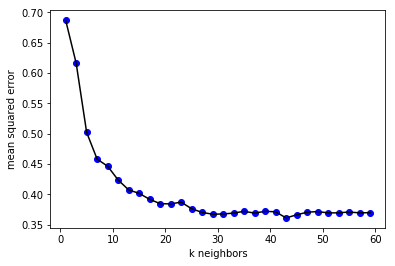

In [96]:
plt.plot(chk['n'],chk['mse'],'bo',chk['n'],chk['mse'],'k')
plt.xlabel('k neighbors')
plt.ylabel('mean squared error')
#plt.title('MSE vs. K-Neighbors graph')
plt.savefig('fig1')

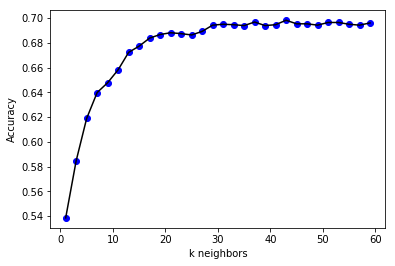

In [97]:
plt.plot(chk['n'],chk['acc'],'bo',chk['n'],chk['acc'],'k')
plt.xlabel('k neighbors')
plt.ylabel('Accuracy')
#plt.title('Accuracy vs. K-Neighbors graph')
plt.savefig('fig2')

In [85]:
def find_result(i):  
    knnclf = neighbors.KNeighborsClassifier(i, weights='distance')
    knnclf.fit(train_array, train_rating)


    predctions = knnclf.predict(test_array)
   
    print("Classification Report ...")
    print(classification_report(test_rating,predctions))

    print("Confussion Matrix....")
    print(confusion_matrix(test_rating,predctions))


    print("n_neighbors  ",i)
    print("Accuracy:    ",accuracy_score(test_rating, predctions))
    print("MSE:         ",mean_squared_error(test_rating, predctions))
    print("\n")

In [98]:
chk

,acc,mse,n
0,0.538434,0.686756,1.0
1,0.584626,0.616023,3.0
2,0.618910,0.501985,5.0
3,0.639841,0.457957,7.0
4,0.647781,0.446409,9.0
5,0.658246,0.423674,11.0
6,0.672320,0.407434,13.0
7,0.677373,0.401660,15.0
8,0.683869,0.391916,17.0
9,0.686756,0.384699,19.0
